# Missing Data

Prerequisites: `00-download-data.ipynb`

Before running the code in this notebook, you must download and concatenate all the original per-day data files into a single parquet file. Please use the above notebook to do this.

In [1]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import osmnx as ox
from ipywidgets import interact, interact_manual
from tqdm import tqdm_notebook as tqdm
import folium
import multiprocessing
import collections

from geo.geomath import vec_haversine, num_haversine
from geo.df import DataCleaner
from par.allel import parallel_process

Read the data in parquet format, as generated by the first step. Note that not all columns are being read in.

In [2]:
columns_to_read = ['Timestamp', 'LineID', 'Direction', 'PatternID', 
                   'JourneyID', 'Congestion', 'Lon', 'Lat', 
                   'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
df = pd.read_parquet("data/sir010113-310113.parquet", columns=columns_to_read)

In [3]:
cleaner = DataCleaner()

In [4]:
vehicles = df['VehicleID']

In [5]:
unique_vehicles = df['VehicleID'].unique()

In [6]:
# def par_remove_speed_anomalies(vd):
#     return { id: vd.id, df: remove_speed_anomalies(vd.df, max_speed=100.0) } 

In [7]:
# VehicleData = collections.namedtuple('VehicleData', ['id', 'df'])

In [8]:
vd = {}
anom = {}
for v in tqdm(unique_vehicles):
    vd[v] = df[df['VehicleID'] == v].copy().sort_values(by='Timestamp')
    vd[v] = cleaner.calculate_derived_columns(vd[v])

In [9]:
df = None

In [10]:
v = unique_vehicles[5]

In [11]:
df = vd[v].copy()

## Calculate type-1 anomalies
These occur when the vehicle is stopped in one observation only and the next has an abnormal speed. This probably happens when the GPS reading fails and defaults to the previous observation, falsely reporting that the vehicle has not moved. The next observation will have the correct time delta but will also have the accumulated distance delta, yielding a falsely high speed.

In [12]:
df_type1 = cleaner.get_type1_anomalies(df)

In [13]:
df_clean1 = cleaner.fix_type1_anomalies(df)

In [14]:
df_clean1.shape

(65241, 17)

In [15]:
df.shape

(68635, 23)

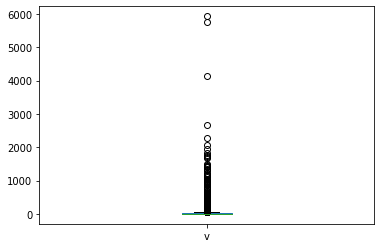

In [16]:
df_clean1['v'].plot.box()

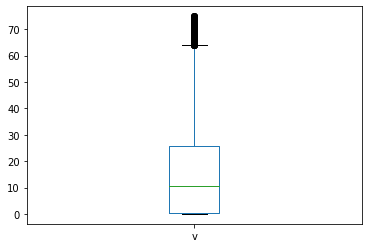

In [23]:
df_clean1[(df_clean1['v'] < 75.0)]['v'].plot.box()

In [ ]:
(vd[v])[i0:i2+1]

In [ ]:
vd[v].iloc[i0]['dt']

In [ ]:
vd[v].iloc[i1]['dt']

In [ ]:
# Recalculate the time difference
vd[v].loc[idx2,'dt'] += vd[v].loc[idx1, 'dt']

In [ ]:
# Recalculate the distance
lat1 = vd[v].loc[idx0, 'Lat']
lon1 = vd[v].loc[idx0, 'Lon']
lat2 = vd[v].loc[idx2, 'Lat']
lon2 = vd[v].loc[idx2, 'Lon']

vd[v].loc[idx2,'dx'] = num_haversine(lat1, lon1, lat2, lon2)

In [ ]:
# Recalculate the speed
vd[v].loc[idx2,'v'] = vd[v].loc[idx2, 'dx'] / vd[v].loc[idx2, 'dt'] * 3.6

In [ ]:
pool = multiprocessing.Pool()
result = pool.map(par_remove_speed_anomalies, vd_tuple)

In [ ]:
df = vd[v].copy()

In [ ]:
anom = df[df['v'] > 70]

In [ ]:
while anom.shape[0] > 0:
    df = df.drop(anom.index[0])
    df = calculate_dt(df, 'Timestamp', 'dt', one_second=1000000)
    df = calculate_dx(df, 'Lat', 'Lon', 'dx')
    df = calculate_speed(df, 'dx', 'dt', 'v')
    anom = df[df['v'] > 70]

In [ ]:
vt1 = df[(df['Day'] == 3)]

In [ ]:
vt0 = vd[v]
vt0 = vt0[vt0['Day'] == 3]

In [ ]:
vt1.shape

In [ ]:
vt0.shape

In [ ]:
v0 = df[df['VehicleID'] == unique_vehicles[0]]

In [ ]:
v0['dt'].max()

In [ ]:
v0['dx'].max()

In [ ]:
v0.to_csv("data/v0.csv", index=False)

In [ ]:
# df[df['VehicleID'] == unique_vehicles[10]].head(20)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df[(df['v'] > 0) & (df['v'] < 80)].boxplot(['v'], figsize=(6,6))

In [ ]:
# df['v'].plot.kde()

In [ ]:
bad_journeys = df[df['v'] > 70]['JourneyID'].unique()

In [ ]:
bad_journeys

In [ ]:
bad_journeys.shape

In [ ]:
df[df['JourneyID'] == bad_journeys[0]].shape

In [ ]:
j0 = df[(df['VehicleID'] == 43055) & (df['Day'] == 2)]

In [ ]:
vt = df[(df['VehicleID'] == 28047) & (df['Day'] == 2)]

In [ ]:
vt = df.loc[(df['JourneyID'] == bad_journeys[0]) & (df['VehicleID'] == 33231)].sort_values(['Timestamp'])

In [ ]:
vt.columns

In [ ]:
vt = df.loc[(df['VehicleID'] == 43055) & (df['Day'] == 2) & (df['Hour'] >= 18)].sort_values(['Timestamp']).copy()

In [ ]:
vt.to_csv("data/vt.csv", index=False)

In [ ]:
lat = vt['Lat'].to_numpy()
lon = vt['Lon'].to_numpy()

In [ ]:
lat.shape[0]

In [ ]:
@interact
def show_trajectory(t=(0, 226, 1)):
    lat = vt['Lat'][:t].to_numpy()
    lon = vt['Lon'][:t].to_numpy()
    plt.plot(lon, lat)

In [ ]:
# for p in points:
#     folium.map.Marker(p).add_to(map)

In [ ]:
# map.save("html/index.html")

In [ ]:
def create_map(df, polyline=True):
    points = list(zip(df['Lat'].to_numpy(), df['Lon'].to_numpy()))
    map = folium.Map()
    map.fit_bounds(points)
    if polyline:
        polyline = folium.vector_layers.PolyLine(points)
        polyline.add_to(map)
    else:
        for pt in points:
            folium.Marker(location=pt).add_to(map)
    return map

In [ ]:
# dd = df[(df['Day']==16) & (df['Hour']==20) & (df['Minute'] > 50)]
dd = df[(df['Day']==17) & (df['Hour'] == 6) & (df['Minute'] > 38)]

create_map(dd, polyline=True)

In [ ]:
df[(df['Day'] == 17) & (df['Hour'] == 6) & (df['Minute'] > 38)]

In [ ]:
df[(df['Day']==16) & (df['Hour']==20) & (df['Minute'] > 50)].to_csv("data/outlier.csv", index=False)

In [ ]:
removed.to_csv("data/removed.csv", index=False)

In [ ]:
df.to_csv("data/retained.csv", index=False)

In [ ]:
vd[v].to_csv("data/original.csv", index=False)

In [ ]:
ox.utils.get_nearest_edges(G, [53.221329, 53.220623, 53.223812], [-6.233653, -6.226733, -6.240146], method='balltree')

In [ ]:
ox.utils.get_nearest_edges(G, [53.220623], [-6.226733], method='balltree')

In [ ]:
ox.utils.get_nearest_edges(G, [53.223812], [-6.240146], method='balltree')